In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 

/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [6]:
### define model ### 
class DAIN_Layer(nn.Module):
    def __init__(self, mode, mean_lr, gate_lr, scale_lr, input_dim):
        super(DAIN_Layer, self).__init__()
        print("Mode = ", mode)
        self.mode = mode
        self.mean_lr = mean_lr
        self.gate_lr = gate_lr
        self.scale_lr = scale_lr
        # Parameters for adaptive average
        self.mean_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.mean_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))
        # Parameters for adaptive std
        self.scaling_layer = nn.Linear(input_dim, input_dim, bias=False)
        self.scaling_layer.weight.data = torch.FloatTensor(data=np.eye(input_dim, input_dim))
        # Parameters for adaptive scaling
        self.gating_layer = nn.Linear(input_dim, input_dim)
        self.eps = 1e-8
    def forward(self, x):
        # Expecting  (n_samples, dim,  n_feature_vectors)
        # Nothing to normalize
        if self.mode == None:
            pass
        # Do simple average normalization
        elif self.mode == 'avg':
            avg = torch.mean(x, 2)
            avg = avg.resize(avg.size(0), avg.size(1), 1)
            x = x - avg
        # Perform only the first step (adaptive averaging)
        elif self.mode == 'adaptive_avg':
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg
        # Perform the first + second step (adaptive averaging + adaptive scaling )
        elif self.mode == 'adaptive_scale':
            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg
            # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1
            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / (adaptive_std)
        elif self.mode == 'full':
            # Step 1:
            avg = torch.mean(x, 2)
            adaptive_avg = self.mean_layer(avg)
            adaptive_avg = adaptive_avg.resize(adaptive_avg.size(0), adaptive_avg.size(1), 1)
            x = x - adaptive_avg
            # # Step 2:
            std = torch.mean(x ** 2, 2)
            std = torch.sqrt(std + self.eps)
            adaptive_std = self.scaling_layer(std)
            adaptive_std[adaptive_std <= self.eps] = 1
            adaptive_std = adaptive_std.resize(adaptive_std.size(0), adaptive_std.size(1), 1)
            x = x / adaptive_std
            # Step 3: 
            avg = torch.mean(x, 2)
            gate = F.sigmoid(self.gating_layer(avg))
            gate = gate.resize(gate.size(0), gate.size(1), 1)
            x = x * gate
        else:
            assert False
        return x

class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, max_len=5000):
                super(PositionalEncoding, self).__init__() 
                self.dropout = nn.Dropout(p=dropout) 
                pe = torch.zeros(max_len, d_model) 
                position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) 
                div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) 
                pe[:, 0::2] = torch.sin(position * div_term) 
                pe[:, 1::2] = torch.cos(position * div_term) 
                pe = pe.unsqueeze(0).transpose(0, 1) 
                self.register_buffer("pe", pe) 
        def forward(self, x):
                x = x + self.pe[:x.size(0), :] 
                return self.dropout(x) 

# returns chart embedding 
class BTCSimCSE(nn.Module): 
        def __init__(self, chart_features, sequence_length, d_model, n_heads, num_encoders):
                super(BTCSimCSE, self).__init__() 
                self.chart_features = chart_features
                self.sequence_length = sequence_length 
                self.d_model = d_model 
                self.n_heads = n_heads 
                self.num_encoders = num_encoders 
                self.dain = DAIN_Layer(mode="full", mean_lr=1e-06, gate_lr=10, scale_lr=0.001, input_dim=self.sequence_length)  
                self.chart_embedder = nn.Sequential(
                        nn.Linear(self.chart_features, d_model//2),
                        nn.ReLU(), 
                        nn.Linear(d_model//2, d_model)
                )
                self.pos_encoder = PositionalEncoding(d_model=self.d_model) 
                self.encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.n_heads, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=self.num_encoders) 
        def forward(self, x): 
                x = self.dain(x) 
                x = self.chart_embedder(x) 
                x = self.pos_encoder(x) 
                x = self.transformer_encoder(x) 
                x = torch.mean(x, dim=1) 
                return x 
            

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")             
checkpoint = torch.load("24_BTC_SIMCSE_val_loss_0.2324610533746513.pt")
            
model = BTCSimCSE(chart_features=1, sequence_length=24, d_model=128, n_heads=8, num_encoders=6) 
model.load_state_dict(checkpoint) 
model.to(device)  
model.eval() 
print() 

Mode =  full



In [7]:
with open("BTC_USDT-1h-12.json") as f: 
        d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
        binance = ccxt.binance() 
        dates = df["timestamp"].values 
        timestamp = [] 
        for i in range(len(dates)):
                date_string = binance.iso8601(int(dates[i])) 
                date_string = date_string[:10] + " " + date_string[11:-5] 
                timestamp.append(date_string) 
        df["datetime"] = timestamp
        df = df.drop(columns={"timestamp"}) 
        return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/47346 [00:00<?, ?it/s]

In [8]:
chart_df.head(3)

,open,high,low,close,volume,datetime,hours,days,months,years
0,4261.48,4313.62,4261.32,4308.83,47.181009,2017-08-17 04:00:00,4,17,8,2017
1,4308.83,4328.69,4291.37,4315.32,23.234916,2017-08-17 05:00:00,5,17,8,2017
2,4330.29,4345.45,4309.37,4324.35,7.229691,2017-08-17 06:00:00,6,17,8,2017


In [9]:
close = chart_df["close"].values 

strides = 10 

seq_len = 24 

start_date_chart_data = {} 

datetimes = chart_df["datetime"].values 

key_dates = [] 

for i in tqdm(range(0, len(datetimes)), position=0, leave=True):
    dt_obj = datetime.strptime(str(datetimes[i]), "%Y-%m-%d %H:%M:%S")  
    start_date_chart_data[dt_obj] = close[i:i+seq_len] 
    key_dates.append(dt_obj) 

  0%|          | 0/4735 [00:00<?, ?it/s]

In [48]:
test_index = 11111

query_close_price = close[test_index:test_index + seq_len] 
query_date = datetimes[test_index] 
query_dt_obj = datetime.strptime(str(query_date), "%Y-%m-%d %H:%M:%S") 

candidate_close_prices, candidate_dates = [], [] 

for key, value in start_date_chart_data.items(): 
    if key + timedelta(hours=30) <= query_dt_obj: # 24 hours + next 6 hours 
        candidate_close_prices.append(value) 
        candidate_dates.append(key) 
        

In [47]:
close.shape

(47346,)

In [49]:
candidate_embeddings = [] 

for i in tqdm(range(len(candidate_close_prices))):
    cur_close = candidate_close_prices[i] 
    cur_close = torch.tensor(cur_close).float() 
    cur_close = torch.reshape(cur_close, (-1, 24, 1)).to(device) 
    with torch.no_grad(): 
        output = model(cur_close) 
    candidate_embeddings.append(output) 
    
candidate_embeddings = torch.cat(candidate_embeddings, dim=0) 

candidate_embeddings.shape

  0%|          | 0/1109 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:538: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:1929: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


torch.Size([1109, 128])

In [50]:
query_close_price = torch.tensor(query_close_price).float() 
query_close_price = torch.reshape(query_close_price, (-1, 24, 1)).to(device) 
with torch.no_grad(): 
    query_embedding = model(query_close_price) 
    
query_embedding.shape

torch.Size([1, 128])

In [51]:
query_embedding = query_embedding.detach().cpu().numpy() 
candidate_embeddings = candidate_embeddings.detach().cpu().numpy() 
sim_scores = cdist(query_embedding, candidate_embeddings, "cosine")[0] 
ranks = np.argsort(sim_scores) 

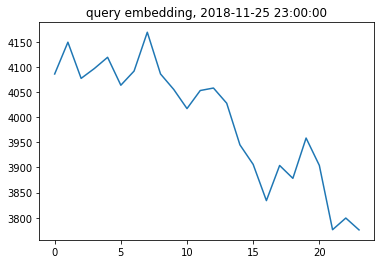

In [52]:
plt.figure()
plt.title(f"query embedding, {query_date}") 
plt.plot(close[test_index:test_index + seq_len]) 
plt.show()

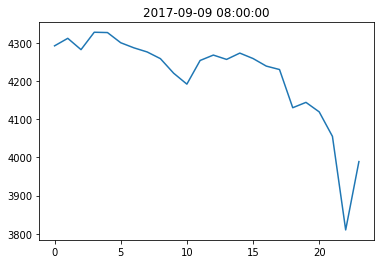

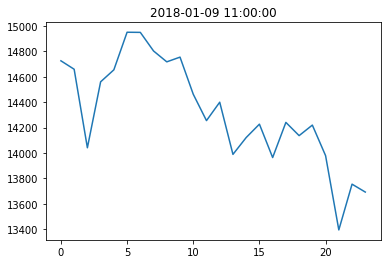

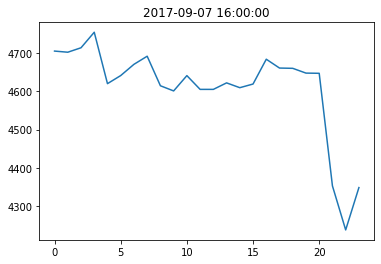

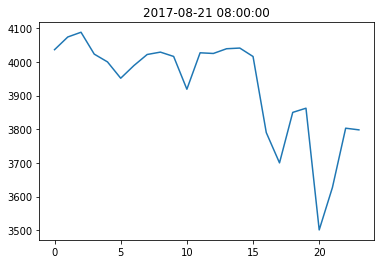

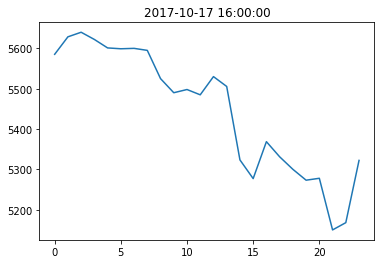

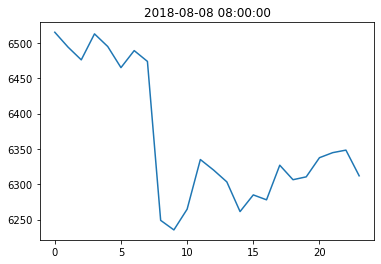

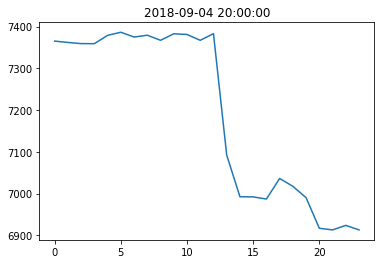

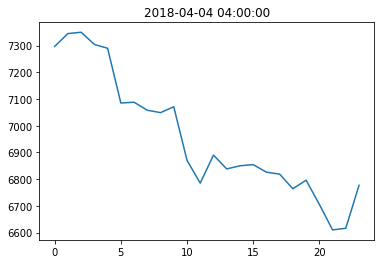

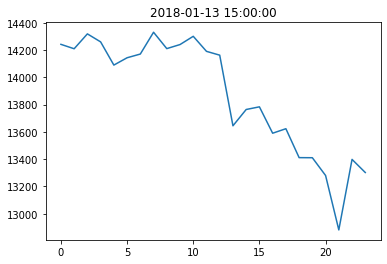

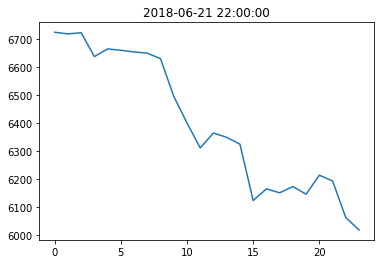

In [53]:
topK = 10 

for i in range(len(ranks[:topK])): 
    plt.figure() 
    plt.title(candidate_dates[ranks[i]])
    plt.plot(candidate_close_prices[ranks[i]])
    plt.show() 